In [ ]:
%pip install pandas matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.



Evaluation Metrics:
 - Mean Squared Error (MSE): 79139.0197
 - Mean Absolute Error (MAE): 166.9998
 - R² Score: 0.8101


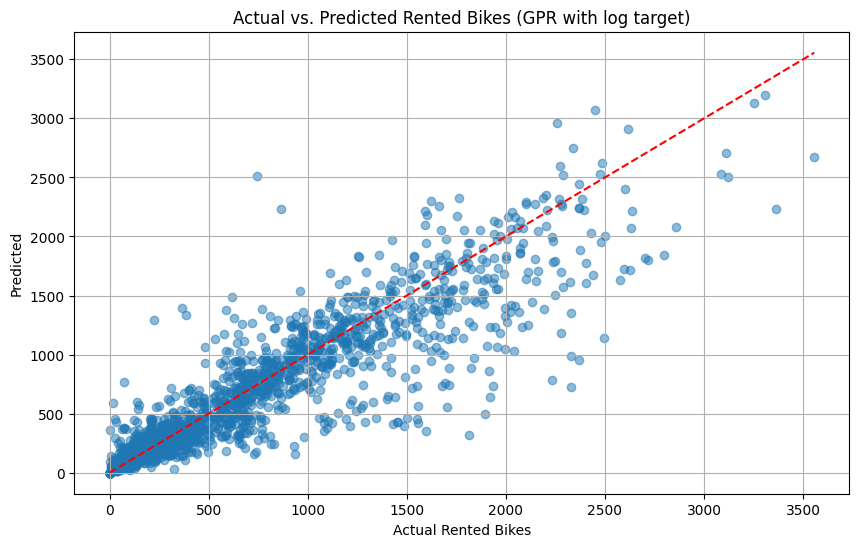

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

# Load dataset
# Load dataset
# 📌 Step 1: Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# 📌 Step 2: Load Your Dataset
# import pandas as pd

# Replace with your actual file path inside Google Drive
file_path = 'dataset/SeoulBikeData.csv'

# Load the dataset
df = pd.read_csv(file_path, encoding='latin1')

# Preview the dataset
df.head()


# df = pd.read_csv("dataset/SeoulBikeData.csv", encoding='latin1')

df.rename(columns={'Rented Bike Count': 'Target'}, inplace=True)

# Encode and preprocess
# df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")  # Correct format: day/month/year
df['Seasons'] = LabelEncoder().fit_transform(df['Seasons'])
df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
df.drop(columns=['Date'], inplace=True)

# Feature selection
features = [
    'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Seasons', 'Holiday', 'Functioning Day'
]
X = df[features]
y = df['Target']

# Log transform the target
y_log = np.log1p(y)

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train_log, y_test_log = train_test_split(X_scaled, y_log, test_size=0.2, random_state=42)

# Define kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=2.0) + WhiteKernel()

# Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2, normalize_y=True)
gpr.fit(X_train, y_train_log)

# Predict and inverse log
y_pred_log, y_std = gpr.predict(X_test, return_std=True)
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nEvaluation Metrics:")
print(f" - Mean Squared Error (MSE): {mse:.4f}")
print(f" - Mean Absolute Error (MAE): {mae:.4f}")
print(f" - R² Score: {r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Rented Bikes")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted Rented Bikes (GPR with log target)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid()
plt.show()



Evaluation Metrics (Original Scale):
 - MSE: 70691.5226
 - MAE: 167.5486
 - R² Score: 0.8303

Evaluation Metrics (Scaled Target 0–1):
 - MSE: 0.0056
 - MAE: 0.0471
 - R² Score: 0.8303


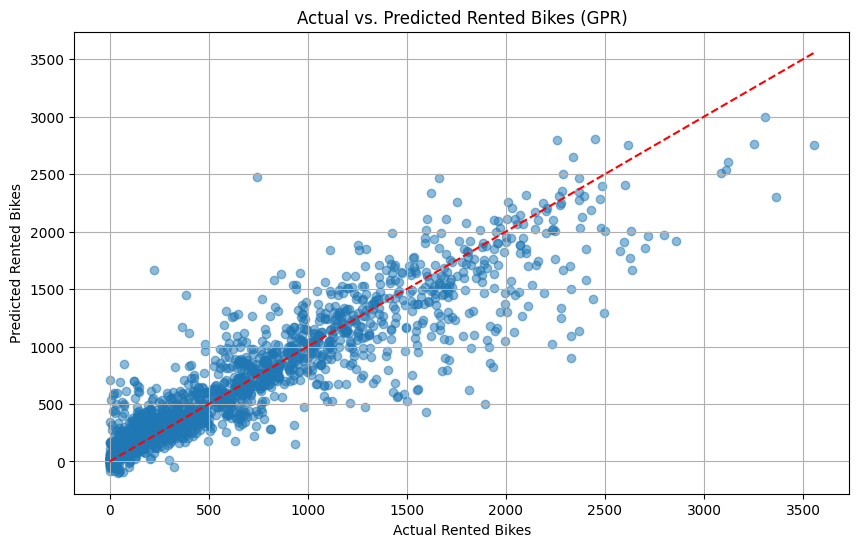

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

# Load dataset
df = pd.read_csv("dataset/SeoulBikeData.csv", encoding='latin1')  # Update path if needed
df.rename(columns={'Rented Bike Count': 'Target'}, inplace=True)

# Preprocessing
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")  # Correct format: day/month/year
df['Seasons'] = LabelEncoder().fit_transform(df['Seasons'])
df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
df.drop(columns=['Date'], inplace=True)

# Feature selection
features = [
    'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Seasons', 'Holiday', 'Functioning Day'
]
X = df[features]
y = df[['Target']]

# Normalize features and target
X_scaled = StandardScaler().fit_transform(X)
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y)

# Train-test split
X_train, X_test, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Kernel and GPR model
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=2.0) + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2, normalize_y=True)
gpr.fit(X_train, y_train_scaled.ravel())

# Predict
y_pred_scaled, y_std = gpr.predict(X_test, return_std=True)
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

# Evaluation (original scale)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Evaluation (scaled target)
mse_scaled = mean_squared_error(y_test_scaled, y_pred_scaled)
mae_scaled = mean_absolute_error(y_test_scaled, y_pred_scaled)
r2_scaled = r2_score(y_test_scaled, y_pred_scaled)

# Print metrics
print("\nEvaluation Metrics (Original Scale):")
print(f" - MSE: {mse:.4f}")
print(f" - MAE: {mae:.4f}")
print(f" - R² Score: {r2:.4f}")

print("\nEvaluation Metrics (Scaled Target 0–1):")
print(f" - MSE: {mse_scaled:.4f}")
print(f" - MAE: {mae_scaled:.4f}")
print(f" - R² Score: {r2_scaled:.4f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Rented Bikes")
plt.ylabel("Predicted Rented Bikes")
plt.title("Actual vs. Predicted Rented Bikes (GPR)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.show()


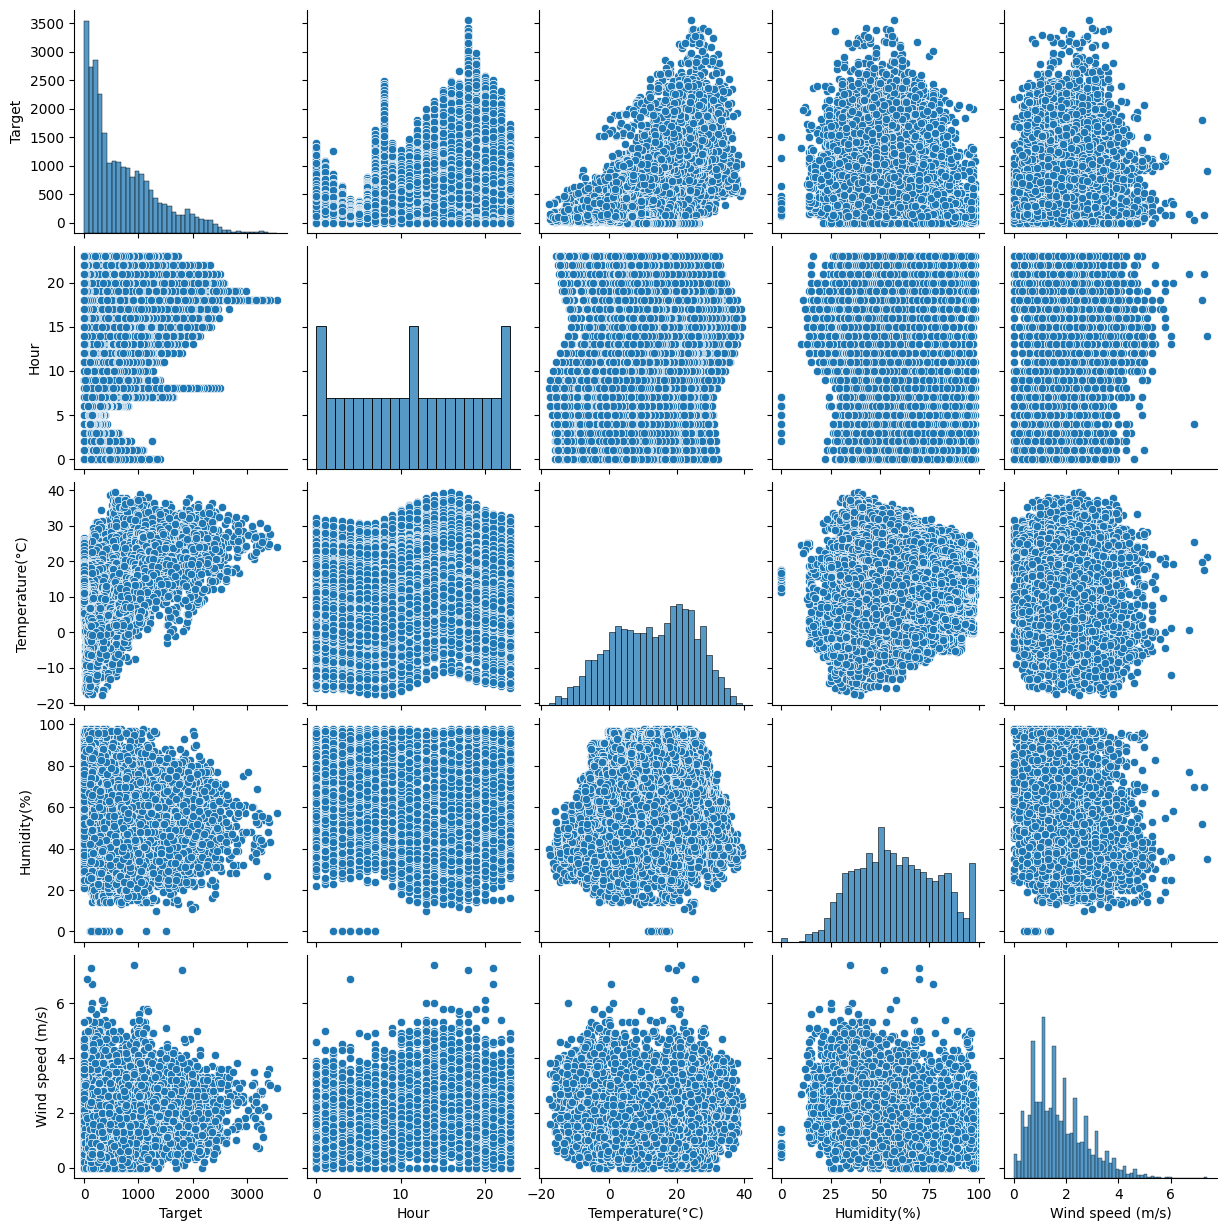

In [6]:
sns.pairplot(df[['Target', 'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)']])

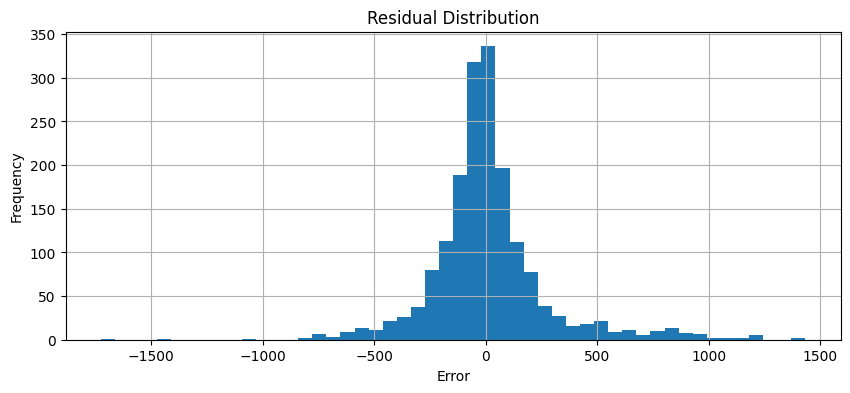

In [7]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 4))
plt.hist(residuals, bins=50)
plt.title("Residual Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

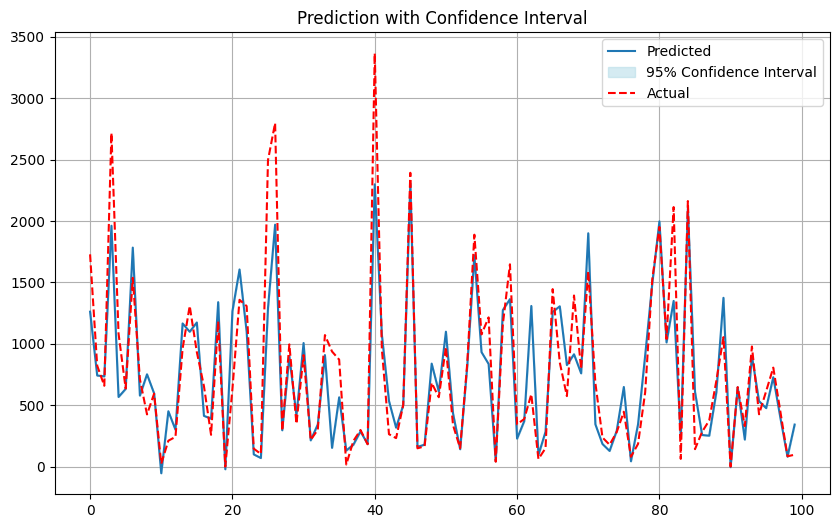

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(range(100), y_pred[:100], label='Predicted')
plt.fill_between(range(100),
                 y_pred[:100] - 1.96 * y_std[:100],
                 y_pred[:100] + 1.96 * y_std[:100],
                 color='lightblue', alpha=0.5, label='95% Confidence Interval')
plt.plot(range(100), y_test[:100], 'r--', label='Actual')
plt.title("Prediction with Confidence Interval")
plt.legend()
plt.grid()
plt.show()


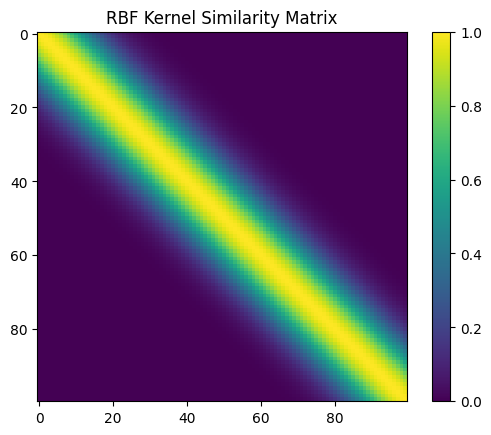

In [9]:
from sklearn.gaussian_process.kernels import Matern
kernel = C(1.0) * Matern(length_scale=1.0, nu=1.5) + WhiteKernel()
df['Target_Class'] = (df['Target'] > 500).astype(int)
from sklearn.gaussian_process.kernels import RBF

x = np.linspace(-5, 5, 100).reshape(-1, 1)
kernel = RBF(length_scale=1.0)
K = kernel(x)

plt.imshow(K, cmap='viridis')
plt.title("RBF Kernel Similarity Matrix")
plt.colorbar()
plt.show()


In [20]:
#Scaling before running code
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# X and y assumed loaded from the dataset
y_scaled = MinMaxScaler().fit_transform(y.values.reshape(-1, 1)).ravel()  # scale target between 0–1
X_scaled = StandardScaler().fit_transform(X)  # standardize features

# Use 1000-sample subset to avoid memory issues
subset_idx = np.random.RandomState(seed=42).choice(len(X_scaled), 1000, replace=False)
X_subset = X_scaled[subset_idx]
y_subset = y_scaled[subset_idx]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)


## RBF

In [21]:
#GPR with RBF Kernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

kernel_rbf = C(1.0) * RBF(length_scale=1.0) + WhiteKernel()
gpr_rbf = GaussianProcessRegressor(kernel=kernel_rbf, alpha=1e-2, normalize_y=True, n_restarts_optimizer=2)
gpr_rbf.fit(X_train, y_train)
y_pred_rbf = gpr_rbf.predict(X_test)

print("📈 RBF Kernel:")
print(f" - MSE: {mean_squared_error(y_test, y_pred_rbf):.4f}")
print(f" - MAE: {mean_absolute_error(y_test, y_pred_rbf):.4f}")
print(f" - R² Score: {r2_score(y_test, y_pred_rbf):.4f}")



📈 RBF Kernel:
 - MSE: 0.0077
 - MAE: 0.0581
 - R² Score: 0.7343


## Matern 1.5

In [22]:
#GPR with Matern (ν=1.5)
from sklearn.gaussian_process.kernels import Matern

kernel_matern_15 = C(1.0) * Matern(length_scale=1.0, nu=1.5) + WhiteKernel()
gpr_matern_15 = GaussianProcessRegressor(kernel=kernel_matern_15, alpha=1e-2, normalize_y=True, n_restarts_optimizer=2)
gpr_matern_15.fit(X_train, y_train)
y_pred_matern_15 = gpr_matern_15.predict(X_test)

print("📈 Matern Kernel (ν=1.5):")
print(f" - MSE: {mean_squared_error(y_test, y_pred_matern_15):.4f}")
print(f" - MAE: {mean_absolute_error(y_test, y_pred_matern_15):.4f}")
print(f" - R² Score: {r2_score(y_test, y_pred_matern_15):.4f}")

📈 Matern Kernel (ν=1.5):
 - MSE: 0.0072
 - MAE: 0.0554
 - R² Score: 0.7491


## Matern 2.5

In [23]:
#GPR with Matern (ν=2.5)
kernel_matern_25 = C(1.0) * Matern(length_scale=1.0, nu=2.5) + WhiteKernel()
gpr_matern_25 = GaussianProcessRegressor(kernel=kernel_matern_25, alpha=1e-2, normalize_y=True, n_restarts_optimizer=2)
gpr_matern_25.fit(X_train, y_train)
y_pred_matern_25 = gpr_matern_25.predict(X_test)

print("📈 Matern Kernel (ν=2.5):")
print(f" - MSE: {mean_squared_error(y_test, y_pred_matern_25):.4f}")
print(f" - MAE: {mean_absolute_error(y_test, y_pred_matern_25):.4f}")
print(f" - R² Score: {r2_score(y_test, y_pred_matern_25):.4f}")


📈 Matern Kernel (ν=2.5):
 - MSE: 0.0073
 - MAE: 0.0560
 - R² Score: 0.7449


## RBF +  Dot Product

In [24]:
#GPR with DotProduct + RBF
from sklearn.gaussian_process.kernels import DotProduct

kernel_dot_rbf = C(1.0) * (DotProduct() + RBF(length_scale=1.0)) + WhiteKernel()
gpr_dot_rbf = GaussianProcessRegressor(kernel=kernel_dot_rbf, alpha=1e-2, normalize_y=True, n_restarts_optimizer=2)
gpr_dot_rbf.fit(X_train, y_train)
y_pred_dot_rbf = gpr_dot_rbf.predict(X_test)

print("📈 DotProduct + RBF Kernel:")
print(f" - MSE: {mean_squared_error(y_test, y_pred_dot_rbf):.4f}")
print(f" - MAE: {mean_absolute_error(y_test, y_pred_dot_rbf):.4f}")
print(f" - R² Score: {r2_score(y_test, y_pred_dot_rbf):.4f}")


📈 DotProduct + RBF Kernel:
 - MSE: 0.0072
 - MAE: 0.0555
 - R² Score: 0.7493


## RBF + Exsinesquared

In [25]:
#GPR with RBF + ExpSineSquared
from sklearn.gaussian_process.kernels import ExpSineSquared

kernel_rbf_sine = C(1.0) * (RBF(length_scale=1.0) + ExpSineSquared(length_scale=1.0, periodicity=3.0)) + WhiteKernel()
gpr_rbf_sine = GaussianProcessRegressor(kernel=kernel_rbf_sine, alpha=1e-2, normalize_y=True, n_restarts_optimizer=2)
gpr_rbf_sine.fit(X_train, y_train)
y_pred_rbf_sine = gpr_rbf_sine.predict(X_test)

print("📈 RBF + ExpSineSquared Kernel:")
print(f" - MSE: {mean_squared_error(y_test, y_pred_rbf_sine):.4f}")
print(f" - MAE: {mean_absolute_error(y_test, y_pred_rbf_sine):.4f}")
print(f" - R² Score: {r2_score(y_test, y_pred_rbf_sine):.4f}")

📈 RBF + ExpSineSquared Kernel:
 - MSE: 0.0074
 - MAE: 0.0565
 - R² Score: 0.7420


<Figure size 1400x600 with 0 Axes>

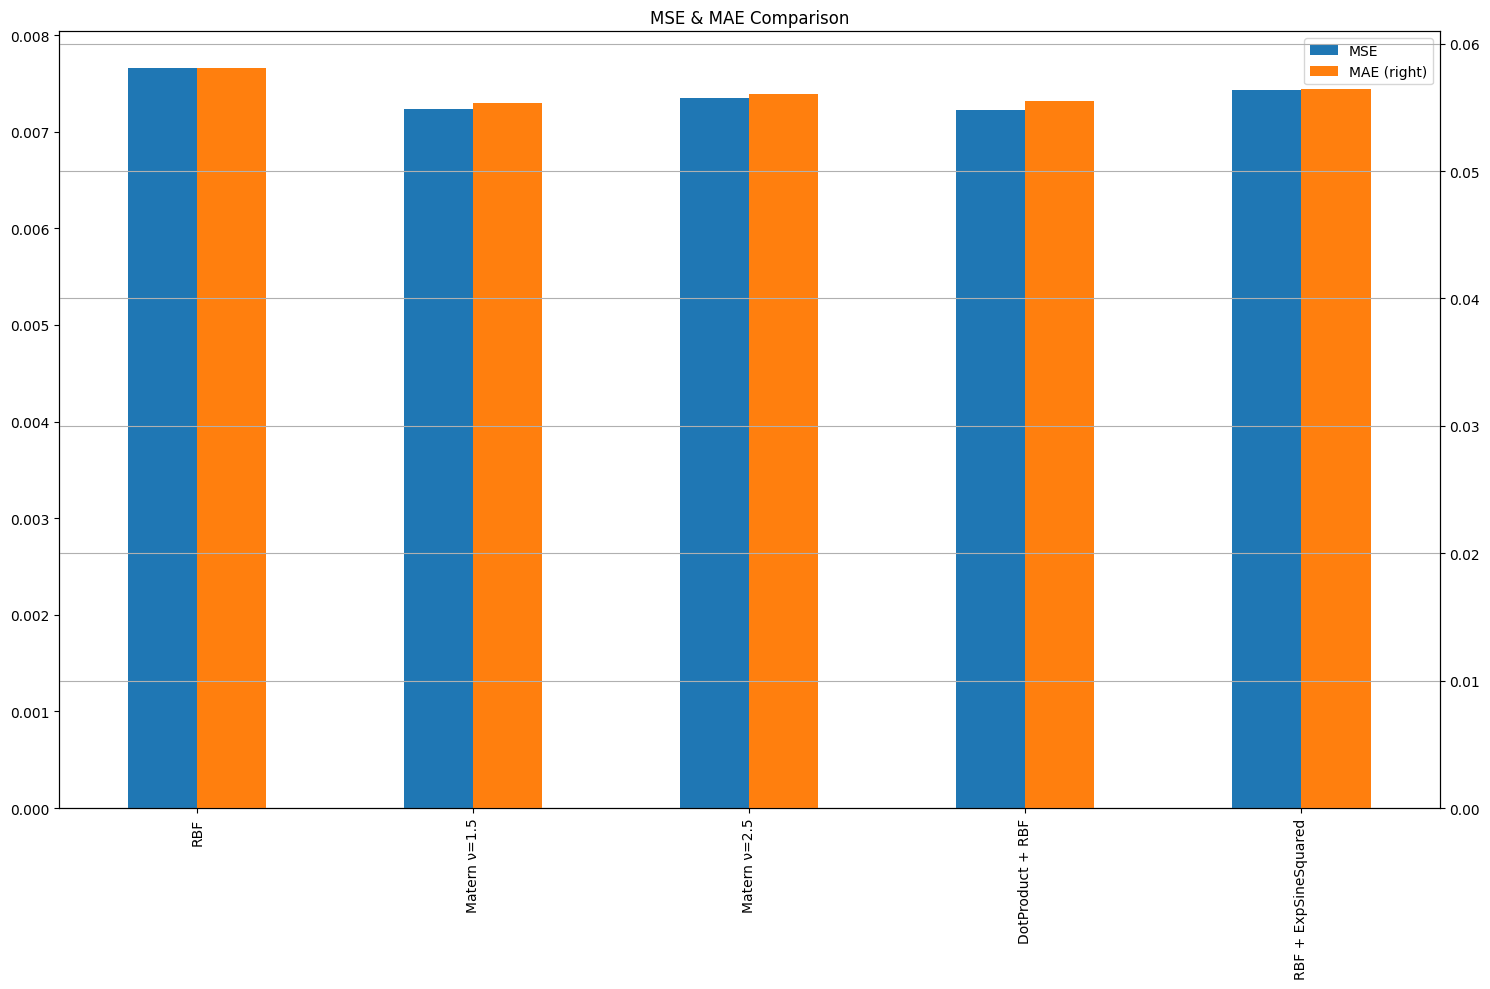

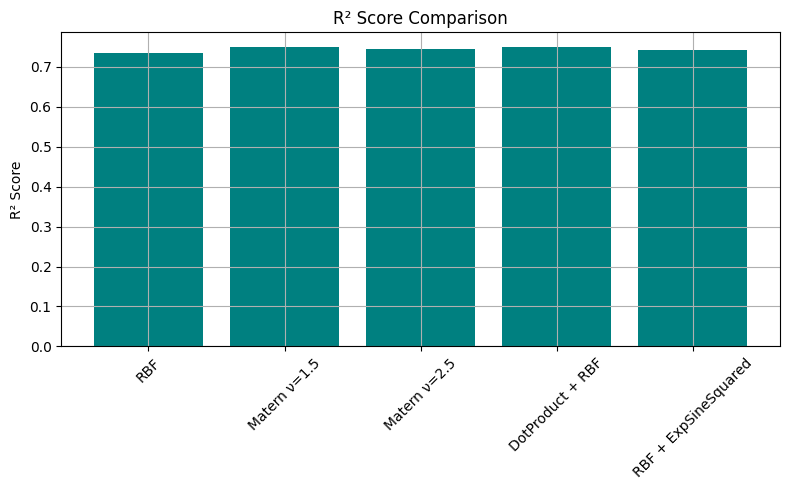

In [32]:
#Comparison Visualization
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Collect evaluation metrics
kernel_results = {
    "RBF": y_pred_rbf,
    "Matern ν=1.5": y_pred_matern_15,
    "Matern ν=2.5": y_pred_matern_25,
    "DotProduct + RBF": y_pred_dot_rbf,
    "RBF + ExpSineSquared": y_pred_rbf_sine
}

results = {}
for name, y_pred in kernel_results.items():
    results[name] = {
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R²": r2_score(y_test, y_pred)
    }

import pandas as pd
results_df = pd.DataFrame(results).T

# Plot
plt.figure(figsize=(14, 6))
results_df[["MSE", "MAE"]].plot(kind='bar', secondary_y="MAE", figsize=(15, 10), title="MSE & MAE Comparison")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(results_df.index, results_df["R²"], color='teal')
plt.title("R² Score Comparison")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
